# Impact parameter resolution for different types of $Z^0 \to f \bar{f}$ events

Here we load different samples of `EDM4Hep` simulation, each one involving $Z^0$ decays to different fermion pairs. We load the tracks from `EFlowTrack_1` and calculate the percentage resolution on the `D0` and `Z0` impact parameter quantities.

In [116]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Loop over different $Z^0 \to f\bar{f}$ samples and load them:

In [117]:
samples = {"mumu": "\\mu\\mu",
           "ee": "ee",
           "bbbar": "b\\bar{b}",
           "ccbar": "c\\bar{c}",
           "qqbar": "q\\bar{q}"}
tree = {}
for s in samples:
    file = uproot.open(f"/eos/experiment/fcc/ee/tmp/ee_Z_{s}_EDM4Hep.root")
    tree[s] = file['events']

Plot making function:

In [120]:
def make_plot(container,var,low,high,bins,log,sample):
    fig, ax = plt.subplots(figsize=(8,8))
    bin_w = (high - low)/bins
    var_name = var.replace("_","\_")
    counts, bin_edges = np.histogram(ak.to_list(ak.flatten(container[var])), bins, range=(low,high))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    err = np.sqrt(counts)
    plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color='k', markersize=2)
    plt.xlabel(f"$\sigma$({var_name})/{var_name} [\%]",fontsize=30)
    plt.ylabel(f"Candidates / ({bin_w:.4f} \%)", fontsize=30)
    plt.xlim(low,high)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ymin, ymax = plt.ylim()
    if(log==True):
        plt.yscale('log')
        plt.ylim(0.1,ymax*1.5)
    else:
        plt.ylim(0.,ymax*1.1)
    plt.title("$Z^0 \\to %s$" % sample,fontsize=25)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{loc.PLOTS}/{s}_{var}_IP_res_per.pdf")

Loop over samples and calculate the percentage resolution on `D0` and `Z0` for all tracks:

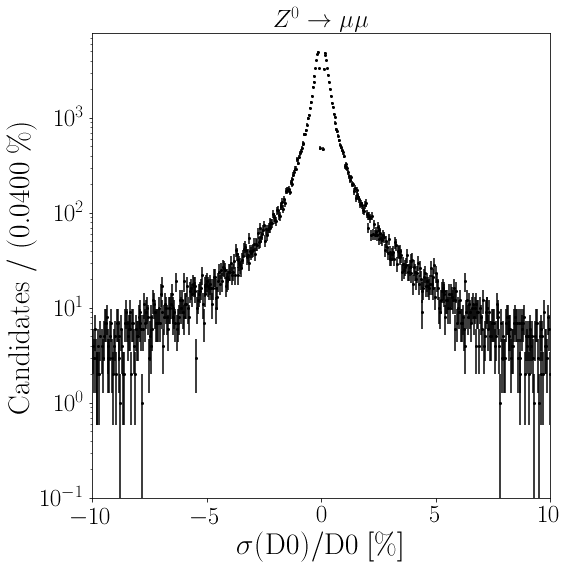

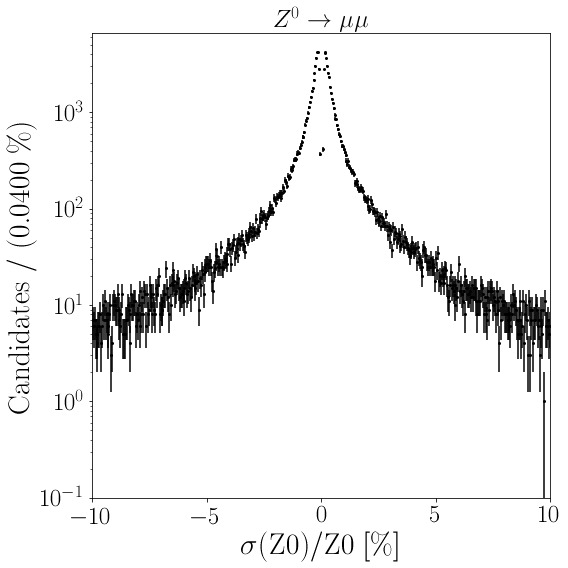

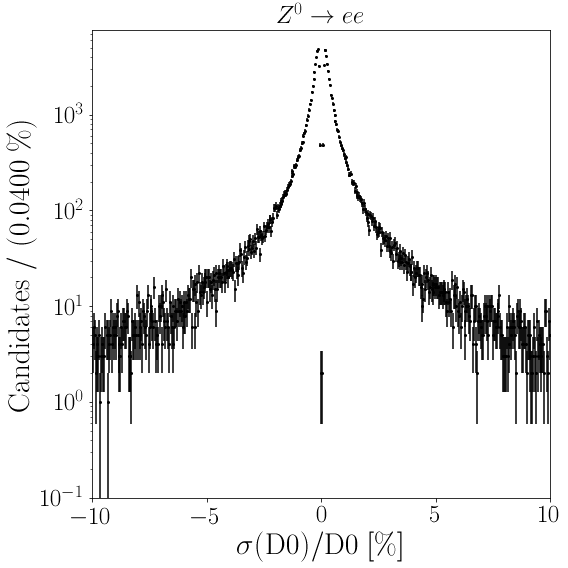

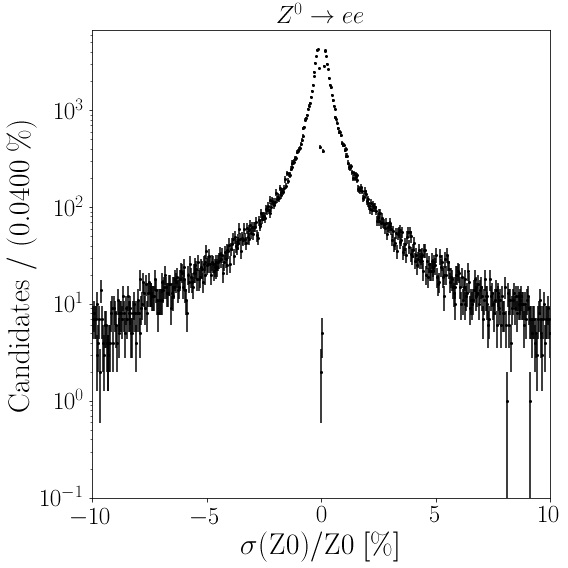

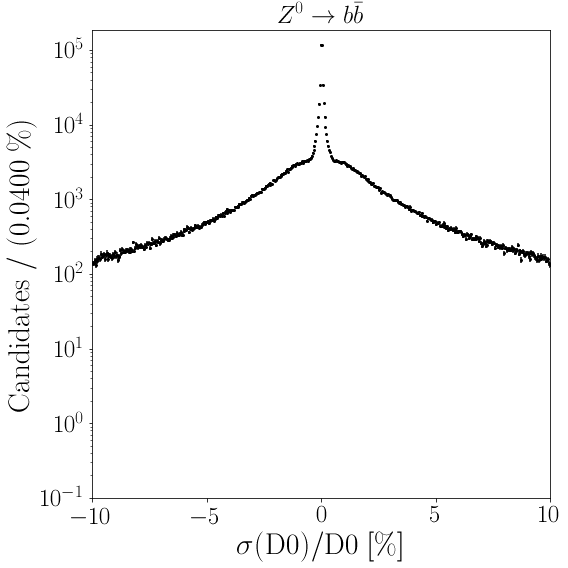

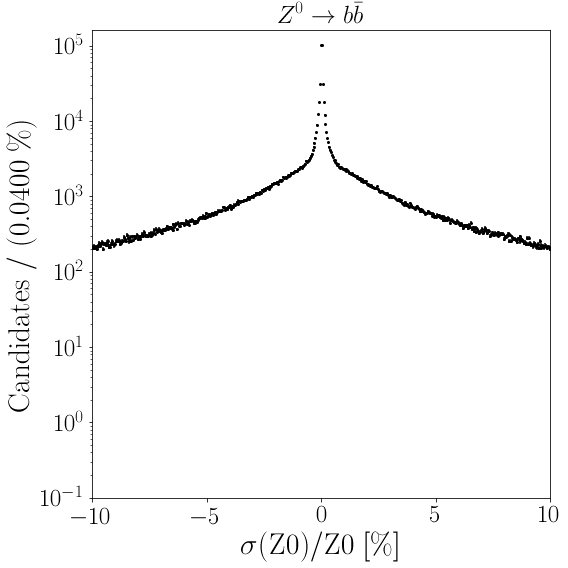

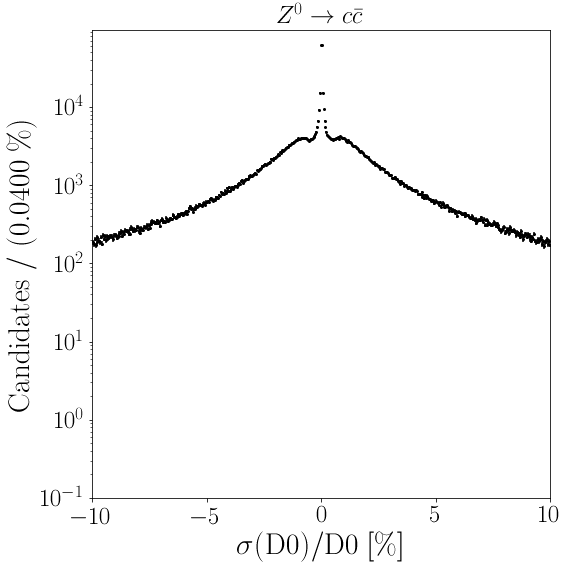

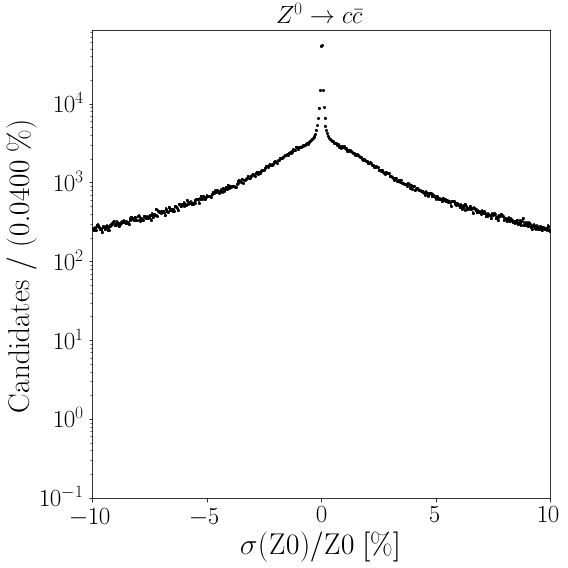

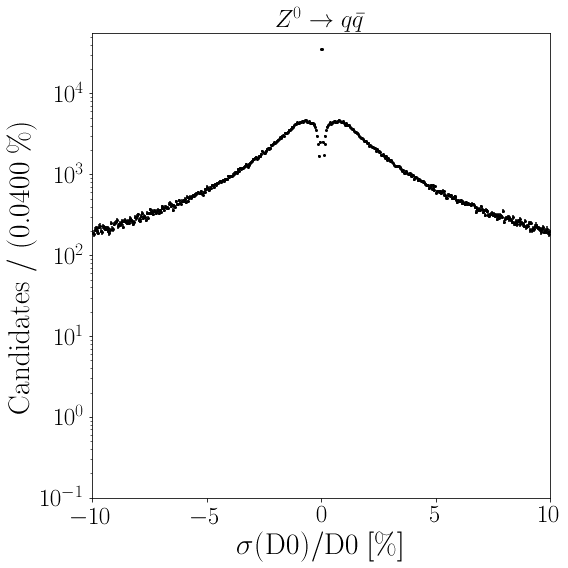

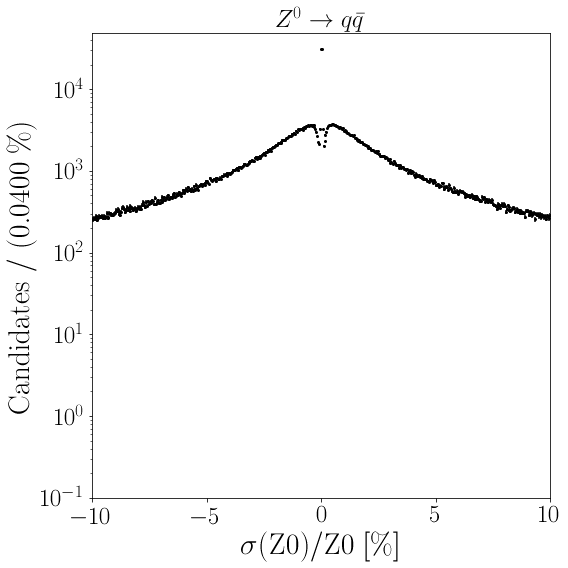

In [121]:
for s in samples:
    
    #Get all the variables in the tree
    vars = tree[s].keys()

    #Loacation of the tracks
    t_container = "EFlowTrack_1"
    t_c = f'{t_container}/{t_container}'

    #Keep the covMatrix
    keep_vars = []
    for v in vars:
        if("covMatrix" in v and t_c in v):
            keep_vars.append(v)

    t_cov = tree[s].arrays(keep_vars,how="zip")

    #Keep everything apart from covMatrix
    keep_vars = []
    for v in vars:
        if("covMatrix" not in v and t_c in v):
            keep_vars.append(v)

    t = tree[s].arrays(keep_vars,how="zip")

    #Location of the diagonal terms in the track covMatrix
    res = {"D0": 0,
           #"phi": 5,
           #"omega": 9,
           "Z0": 12,
           #"tanLambda": 14
          }

    res_vals = {}
    vals = {}
    res_vals_per = {}

    for r in res:
        #Get values for all particles in all events
        #First : is events, second is particles, and res[r] points to the index in the covMatrix
        res_vals[r] = t_cov[t_c,"covMatrix[15]"][:,:,res[r]]
        #Impact parameter values
        vals[r] = t[t_c,r]
        #Percentage resolution on the IP
        res_vals_per[r] = 100*(res_vals[r] / vals[r])

    #Plotting
    low = -10
    high = 10
    bins = 500
    for r in res:
        make_plot(res_vals_per,r,low,high,bins,True,samples[s])